# 0. Data set selection

For gold ETF, we choose SPDR Gold Shares ETF, symbol `GLD`
For equity ETF outside US, we choose iShares MSCI India ETF, symbol `INDA`


Data source: https://finance.yahoo.com

# 1. Data Importing

In [1]:
import arch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from scipy import stats
from nelson_siegel_svensson import NelsonSiegelSvenssonCurve
from nelson_siegel_svensson.calibrate import calibrate_nss_ols
%matplotlib inline


/Users/nguynha/.asdf/installs/python/3.8.6/lib/python3.8/site-packages/pandas/compat/__init__.py:97: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


Load data from CSV into Panda's dataframe

In [2]:
gold_df = pd.read_csv('SPDR_GOLD.csv')
india_df = pd.read_csv('INDA.csv')
treasury_df = pd.read_csv('Treasury.csv')

Convert the data into the datetime format and index it for easier query.


In [3]:
gold_df["Date"] = pd.to_datetime(gold_df["Date"], format="%m/%d/%Y")
gold_df.set_index("Date", inplace=True)
india_df["Date"] = pd.to_datetime(india_df["Date"], format="%m/%d/%Y")
india_df.set_index("Date", inplace=True)

Verify that the time range is correct.

In [4]:
gold_df.head()

,Open,High_Value,Low_Value,Close,Volume,Adjusted_Price
Date,,,,,,
2019-10-01,138.070007,140.190002,137.800003,139.630005,12476200,139.630005
2019-10-02,140.789993,141.880005,140.460007,141.259995,11914300,141.259995
2019-10-03,141.360001,143.250000,141.289993,141.899994,12396100,141.899994
2019-10-04,141.479996,142.309998,141.139999,141.899994,9651000,141.899994
2019-10-07,141.160004,141.770004,140.240005,140.690002,6127200,140.690002


In [5]:
gold_df.tail()

,Open,High_Value,Low_Value,Close,Volume,Adjusted_Price
Date,,,,,,
2019-11-22,138.369995,138.460007,137.660004,137.740005,3620300,137.740005
2019-11-25,137.320007,137.619995,136.990005,137.080002,6415800,137.080002
2019-11-26,136.979996,137.800003,136.580002,137.740005,4724400,137.740005
2019-11-27,137.029999,137.210007,136.830002,137.009995,4111000,137.009995
2019-11-29,137.100006,138.130005,137.080002,137.860001,4516400,137.860001


In [6]:
india_df.head()

,Open,High,Low,Close,Adj Close,Volume,Adjusted_Price
Date,,,,,,,
2019-10-01,32.980000,32.980000,32.740002,32.779999,32.603642,4870800,32.603642
2019-10-02,32.599998,32.700001,32.520000,32.639999,32.464397,3958600,32.464397
2019-10-03,32.799999,33.020000,32.790001,32.990002,32.812511,4543200,32.812511
2019-10-04,32.689999,32.830002,32.599998,32.770000,32.593697,3193700,32.593697
2019-10-07,32.500000,32.560001,32.369999,32.389999,32.215740,4388000,32.215740


In [7]:
india_df.tail()

,Open,High,Low,Close,Adj Close,Volume,Adjusted_Price
Date,,,,,,,
2019-11-22,34.200001,34.270000,34.150002,34.200001,34.016003,1850600,34.016003
2019-11-25,34.770000,34.919998,34.709999,34.910000,34.722179,3578600,34.722179
2019-11-26,34.779999,34.820000,34.680000,34.790001,34.602833,5311800,34.602833
2019-11-27,34.959999,35.070000,34.869999,35.060001,34.871380,4053900,34.871380
2019-11-29,34.549999,34.619999,34.450001,34.459999,34.274605,3403700,34.274605


In [8]:
treasury_df.head()

,Date,2 Year Price,3 Year Price,5 Year Price,7 Year Price,10 Year Price,30 Year Price
0,"Oct 01, 2019",1.542,1.494,1.489,1.571,1.635,2.091
1,"Oct 02, 2019",1.484,1.435,1.435,1.528,1.601,2.088
2,"Oct 03, 2019",1.392,1.351,1.349,1.450,1.534,2.031
3,"Oct 04, 2019",1.406,1.361,1.349,1.446,1.529,2.014
4,"Oct 06, 2019",1.386,1.342,1.331,1.429,1.515,2.008


In [9]:
treasury_df.tail()


,Date,2 Year Price,3 Year Price,5 Year Price,7 Year Price,10 Year Price,30 Year Price
45,"Nov 25, 2019",1.611,1.595,1.607,1.692,1.752,2.197
46,"Nov 26, 2019",1.590,1.579,1.596,1.683,1.741,2.178
47,"Nov 27, 2019",1.626,1.617,1.627,1.718,1.767,2.189
48,"Nov 28, 2019",1.628,1.622,1.636,1.723,1.778,2.201
49,"Nov 29, 2019",1.612,1.609,1.624,1.729,1.774,2.203


# 2. Data Processing

We use adjusted close prices to calculate the daily returns. Adjusted close prices are the prices that already take into account stock split and dividends, which reflex more accurate the change of the prices.

In [10]:
gold_df["Daily Return"] = gold_df["Adjusted_Price"].pct_change(1)
gold_df.head()

,Open,High_Value,Low_Value,Close,Volume,Adjusted_Price,Daily Return
Date,,,,,,,
2019-10-01,138.070007,140.190002,137.800003,139.630005,12476200,139.630005,NaN
2019-10-02,140.789993,141.880005,140.460007,141.259995,11914300,141.259995,0.011674
2019-10-03,141.360001,143.250000,141.289993,141.899994,12396100,141.899994,0.004531
2019-10-04,141.479996,142.309998,141.139999,141.899994,9651000,141.899994,0.000000
2019-10-07,141.160004,141.770004,140.240005,140.690002,6127200,140.690002,-0.008527


In [11]:
india_df["Daily Return"] = india_df["Adjusted_Price"].pct_change(1)
india_df.head()

# 3. Data Summaries

,Open,High,Low,Close,Adj Close,Volume,Adjusted_Price,Daily Return
Date,,,,,,,,
2019-10-01,32.980000,32.980000,32.740002,32.779999,32.603642,4870800,32.603642,NaN
2019-10-02,32.599998,32.700001,32.520000,32.639999,32.464397,3958600,32.464397,-0.004271
2019-10-03,32.799999,33.020000,32.790001,32.990002,32.812511,4543200,32.812511,0.010723
2019-10-04,32.689999,32.830002,32.599998,32.770000,32.593697,3193700,32.593697,-0.006669
2019-10-07,32.500000,32.560001,32.369999,32.389999,32.215740,4388000,32.215740,-0.011596


In [12]:
df_October = treasury_df[treasury_df['Date'].str.contains("Oct")]
df_November = treasury_df[treasury_df['Date'].str.contains("Nov")]
print("Average October Yield is \n{}\n".format(np.mean(df_October)))
print("Average November Yield is \n{}".format(np.mean(df_November)))
print("Standard Deviation for October Yield is \n{}".format(np.std(df_October)))
print("Standard Deviation for November Yield is \n{}".format(np.std(df_November)))

Average October Yield is 
 2 Year Price    1.551385
3 Year Price     1.527154
5 Year Price     1.525115
7 Year Price     1.614000
10 Year Price    1.701423
30 Year Price    2.187269
dtype: float64

Average November Yield is 
 2 Year Price    1.616750
3 Year Price     1.618042
5 Year Price     1.641167
7 Year Price     1.736833
10 Year Price    1.811625
30 Year Price    2.276708
dtype: float64
Standard Deviation for October Yield is 
 2 Year Price    0.079354
3 Year Price     0.094165
5 Year Price     0.101524
7 Year Price     0.098831
10 Year Price    0.102293
30 Year Price    0.101143
dtype: float64
Standard Deviation for November Yield is 
 2 Year Price    0.033516
3 Year Price     0.044156
5 Year Price     0.054878
7 Year Price     0.062000
10 Year Price    0.067403
30 Year Price    0.079564
dtype: float64


In [13]:
gold_df["High minus low"] = gold_df["High_Value"] - gold_df["Low_Value"]
india_df["High minus low"] = india_df["High"] - india_df["Low"]

In [14]:
gold_df.resample('M').mean()

,Open,High_Value,Low_Value,Close,Volume,Adjusted_Price,Daily Return,High minus low
Date,,,,,,,,
2019-10-31,140.847391,141.384349,140.303043,140.874782,7.757287e+06,140.874782,0.000921,1.081305
2019-11-30,138.611500,139.056000,138.083502,138.570500,6.961465e+06,138.570500,-0.001611,0.972498


In [15]:
india_df.resample('M').mean()

,Open,High,Low,Close,Adj Close,Volume,Adjusted_Price,Daily Return,High minus low
Date,,,,,,,,,
2019-10-31,33.388696,33.499565,33.310435,33.418261,33.238471,4.098735e+06,33.238471,0.002553,0.18913
2019-11-30,34.529500,34.599500,34.435500,34.511500,34.325828,3.144340e+06,34.325828,-0.000238,0.16400


In [16]:
gold_df.resample('M').std()

,Open,High_Value,Low_Value,Close,Volume,Adjusted_Price,Daily Return,High minus low
Date,,,,,,,,
2019-10-31,0.972620,0.929309,0.950674,0.831229,2.804293e+06,0.831229,0.006173,0.479405
2019-11-30,1.618235,1.588269,1.585444,1.562095,2.994154e+06,1.562095,0.006188,0.492552


In [17]:
india_df.resample('M').std()

,Open,High,Low,Close,Adj Close,Volume,Adjusted_Price,Daily Return,High minus low
Date,,,,,,,,,
2019-10-31,0.758380,0.762158,0.757181,0.771802,0.76765,1.185106e+06,0.76765,0.007731,0.061490
2019-11-30,0.386448,0.405430,0.380325,0.406517,0.40433,1.099814e+06,0.40433,0.008771,0.037332


# 4. Graphing

<AxesSubplot:xlabel='Date'>

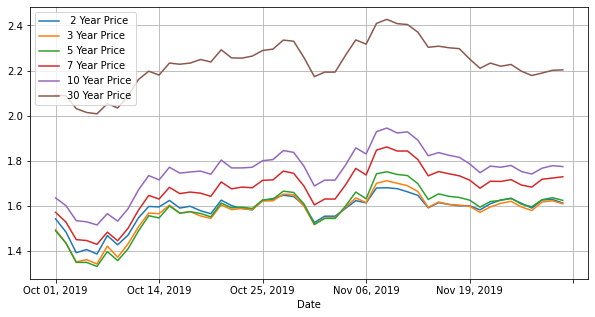

In [18]:
treasury_df.set_index('Date').plot(figsize=(10,5), grid=True)

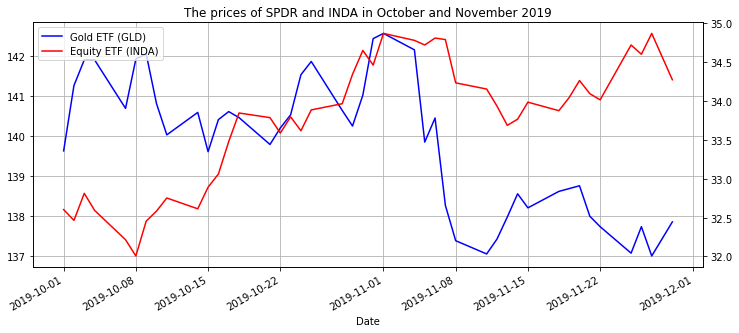

In [19]:
plt.figure(figsize=(12,5))
plt.title('The prices of SPDR and INDA in October and November 2019')

ax1 = gold_df["Adjusted_Price"].plot(color='blue', grid=True, label='Gold ETF (GLD)')
ax2 = india_df["Adj Close"].plot(color='red', grid=True, secondary_y=True, label='Equity ETF (INDA)')

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()

plt.legend(h1+h2, l1+l2, loc=2)
plt.show()

# 5. Fitting the yield curve

NelsonSiegelSvenssonCurve(beta0=2.6300567186024466, beta1=-0.6944401715451543, beta2=-1.3188222648949588, beta3=-2.018679134498531, tau1=1.628124693574661, tau2=5.1724710548474535)


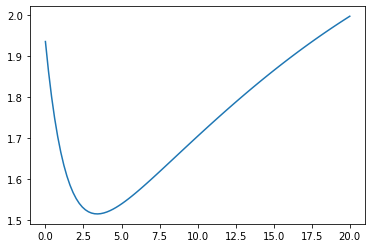

NelsonSiegelSvenssonCurve(beta0=5.52340563576597, beta1=-3.629031261789744, beta2=-3.39683420720158, beta3=-9.003197383508716, tau1=2.541013822140346, tau2=14.00058811425833)


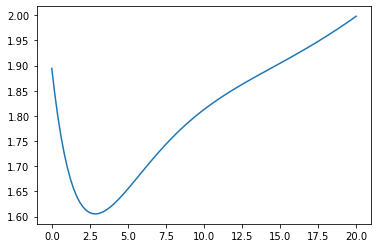

In [20]:
t =np.array([2.0,3.0,5.0,7.0,10.0,30.0])
#avarage yield rate for October
y = np.array([1.551,1.527,1.525,1.614,1.701,2.18])

curve_fit, status = calibrate_nss_ols(t,y)
nss_zc = NelsonSiegelSvenssonCurve.zero(curve_fit,t)
nss_zc

curve_oct, status = calibrate_nss_ols(t,nss_zc)
assert status.success
print(curve_oct)

t = np.linspace(0,20,100)
plt.plot(t,curve_oct(t))
plt.show()

#avarage yield rate for November
t =np.array([2.0,3.0,5.0,7.0,10.0,30.0])
y = np.array([1.616,1.618,1.641,1.736,1.811,2.276])

curve_fit, status = calibrate_nss_ols(t,y)
nss_zc = NelsonSiegelSvenssonCurve.zero(curve_fit,t)
nss_zc

curve_nov, status = calibrate_nss_ols(t,nss_zc)
assert status.success
print(curve_nov)

t = np.linspace(0,20,100)
plt.plot(t,curve_nov(t))
plt.show()

# 6. Modelling Prices

In [21]:
def get_data(df, month, column):
    return df[(df.index >= f"2019-{month:02d}-01") & (df.index < f"2019-{(month+1):02d}-01")][column]

In [22]:
def fit_arima(data):
    model = ARIMA(data, order=(3,0,3))
    model_fit = model.fit()
    print(model_fit.summary())
    residuals = pd.DataFrame(model_fit.resid)
    ax1 = residuals.plot(label='residual')
    plt.title("Residuals during the month")
    ax1.get_legend().remove()
    plt.show()
    ax2 = residuals.plot(kind='kde')
    plt.title("Kernel density estimation of the residuals")
    ax2.get_legend().remove()
    plt.show()

--------------------------------------------------------------------------------
ARMA model for Gold ETF (GLD) in October


/Users/nguynha/.asdf/installs/python/3.8.6/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  warnings.warn('No frequency information was'
/Users/nguynha/.asdf/installs/python/3.8.6/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  warnings.warn('No frequency information was'
/Users/nguynha/.asdf/installs/python/3.8.6/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  warnings.warn('No frequency information was'
/Users/nguynha/.asdf/installs/python/3.8.6/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting auto

                               SARIMAX Results                                
Dep. Variable:         Adjusted_Price   No. Observations:                   23
Model:                 ARIMA(3, 0, 3)   Log Likelihood                 -21.992
Date:                Mon, 28 Jun 2021   AIC                             59.985
Time:                        08:58:26   BIC                             69.069
Sample:                    10-01-2019   HQIC                            62.269
                         - 10-31-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        140.8067      0.109   1290.208      0.000     140.593     141.021
ar.L1          0.0995      0.407      0.245      0.807      -0.698       0.897
ar.L2          0.4517      0.387      1.168      0.2

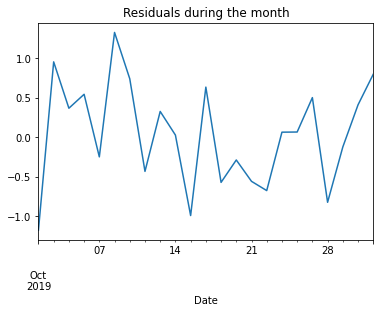

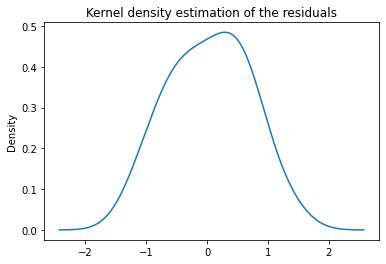

--------------------------------------------------------------------------------
ARMA model for Gold ETF (GLD) in November
                               SARIMAX Results                                
Dep. Variable:         Adjusted_Price   No. Observations:                   20
Model:                 ARIMA(3, 0, 3)   Log Likelihood                 -22.205
Date:                Mon, 28 Jun 2021   AIC                             60.409
Time:                        08:58:26   BIC                             68.375
Sample:                             0   HQIC                            61.964
                                 - 20                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        138.8145      0.871    159.316      0.000     137.107     140.522
ar.L1   

/Users/nguynha/.asdf/installs/python/3.8.6/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/nguynha/.asdf/installs/python/3.8.6/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/nguynha/.asdf/installs/python/3.8.6/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/nguynha/.asdf/installs/python/3.8.6/lib/python3.8/site

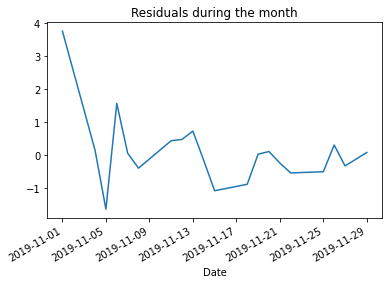

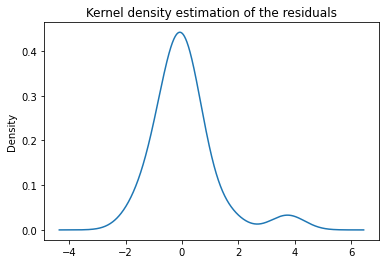

--------------------------------------------------------------------------------
ARMA model for Equity ETF (INDA) in October
                               SARIMAX Results                                
Dep. Variable:         Adjusted_Price   No. Observations:                   23
Model:                 ARIMA(3, 0, 3)   Log Likelihood                  -1.241
Date:                Mon, 28 Jun 2021   AIC                             18.481
Time:                        08:58:27   BIC                             27.565
Sample:                    10-01-2019   HQIC                            20.766
                         - 10-31-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         33.4148      0.671     49.797      0.000      32.100      34.730
ar.L1 

/Users/nguynha/.asdf/installs/python/3.8.6/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  warnings.warn('No frequency information was'
/Users/nguynha/.asdf/installs/python/3.8.6/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  warnings.warn('No frequency information was'
/Users/nguynha/.asdf/installs/python/3.8.6/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  warnings.warn('No frequency information was'
/Users/nguynha/.asdf/installs/python/3.8.6/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting auto

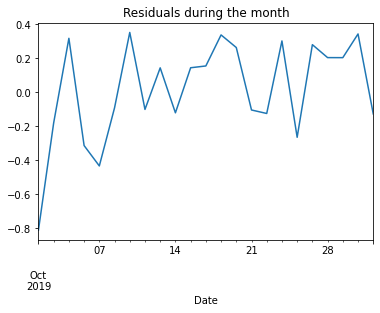

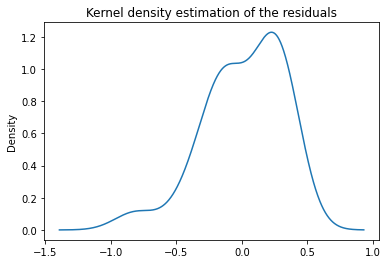

--------------------------------------------------------------------------------
ARMA model for Equity ETF (INDA) in November
                               SARIMAX Results                                
Dep. Variable:         Adjusted_Price   No. Observations:                   20
Model:                 ARIMA(3, 0, 3)   Log Likelihood                   1.945
Date:                Mon, 28 Jun 2021   AIC                             12.111
Time:                        08:58:27   BIC                             20.076
Sample:                             0   HQIC                            13.666
                                 - 20                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         34.2549      0.065    529.631      0.000      34.128      34.382
ar.L1

/Users/nguynha/.asdf/installs/python/3.8.6/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/nguynha/.asdf/installs/python/3.8.6/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/nguynha/.asdf/installs/python/3.8.6/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/nguynha/.asdf/installs/python/3.8.6/lib/python3.8/site

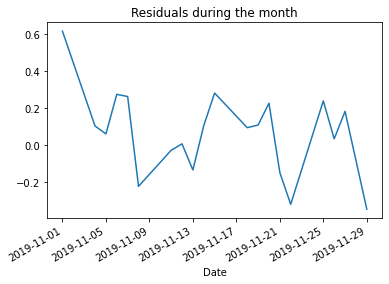

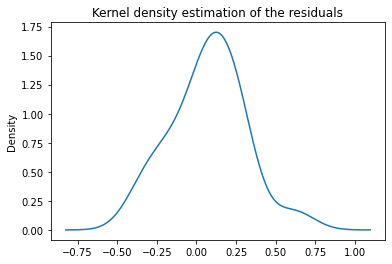

In [23]:
df_name = {0: "Gold ETF (GLD)", 1: "Equity ETF (INDA)"}
month_name = {10: "October", 11: "November"}
for index, df in enumerate([gold_df, india_df]):
    for month in [10, 11]:
        print("-" * 78)
        print('ARMA model for {} in {}'.format(df_name[index], month_name[month]))
        data = get_data(df, month, "Adjusted_Price")
        fit_arima(data)

# 7. Modelling Volatility

In [24]:
def fit_garch(data):
    garch = arch.arch_model(data, vol='garch', p=1, o=0, q=1)
    garch_fitted = garch.fit()
    print(garch_fitted.summary())

In [25]:
for index, df in enumerate([gold_df, india_df]):
    for month in [10, 11]:
        print("-" * 8)
        print("-" * 8)
        print("-" * 8)
        print(f"GARCH model for {df_name[index]} in {month_name[month]}")
        data = get_data(df, month, "Daily Return")
        data = data.dropna()
        fit_garch(data)

--------
--------
--------
GARCH model for Gold ETF (GLD) in October
Iteration:      1,   Func. Count:      6,   Neg. LLF: 2211987.449503363
Iteration:      2,   Func. Count:     16,   Neg. LLF: -81.257589920448
Optimization terminated successfully    (Exit mode 0)
            Current function value: -81.25758995275967
            Iterations: 6
            Function evaluations: 16
            Gradient evaluations: 2
                     Constant Mean - GARCH Model Results                      
Dep. Variable:           Daily Return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                81.2576
Distribution:                  Normal   AIC:                          -154.515
Method:            Maximum Likelihood   BIC:                          -150.151
                                        No. Observations:                   22
Date:                Mon, J

/Users/nguynha/.asdf/installs/python/3.8.6/lib/python3.8/site-packages/arch/univariate/base.py:316: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 3.638e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/nguynha/.asdf/installs/python/3.8.6/lib/python3.8/site-packages/arch/univariate/base.py:316: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 3.638e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/nguynha/.asdf

# 8. Correlation

In [26]:
#October correlation

In [27]:
corr_oct = stats.pearsonr(gold_df[("2019-10-01" < gold_df.index) & (gold_df.index < "2019-11-01")]["Daily Return"], india_df[("2019-10-01" < india_df.index) & (india_df.index < "2019-11-01")]["Daily Return"])[0]
print('The correlation of gold and equity ETFs in October is {}'.format(corr_oct))

The correlation of gold and equity ETFs in October is -0.1715275917007279


In [28]:
#November correlation

In [29]:
corr_nov = stats.pearsonr(gold_df[gold_df.index >= "2019-11-01"]["Daily Return"], india_df[india_df.index >= "2019-11-01"]["Daily Return"])[0]
print('The correlation of gold and equity ETFs in November is {}'.format(corr_oct))

The correlation of gold and equity ETFs in November is -0.1715275917007279
